In [1]:
# Set to have less messages from distributed
import dask
dask.config.set({"logging.distributed": "error"})
#dask.config.set(fuse_ave_width=2)

In [2]:
from dask.distributed import Client

client = Client("tcp://10.32.10.8:41877")
client

<Client: 'tcp://10.32.10.8:41877' processes=1 threads=2, memory=11.50 GB>

In [3]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake

from matplotlib import pyplot as plt
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [4]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

In [5]:
coords = cat.LLC4320_grid(chunks=False).to_dask().isel(face=1).reset_coords()

In [6]:
coords = coords.chunk({'time':1})

In [7]:
sss = cat.LLC4320_SSS().to_dask().isel(face=1, 
                                i = slice(0,2000,20), j = slice(0,2000,20))

In [8]:
sss.SSS

<xarray.DataArray 'SSS' (time: 9030, j: 100, i: 100)>
dask.array<getitem, shape=(9030, 100, 100), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    face     int64 1
  * i        (i) int64 0 20 40 60 80 100 120 ... 1880 1900 1920 1940 1960 1980
  * j        (j) int64 0 20 40 60 80 100 120 ... 1880 1900 1920 1940 1960 1980
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [13]:
subset_factor = 5
sss_sub = (sss.SSS.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,120*24))
                 .chunk({'time': 1}))

In [14]:
sss_sub

<xarray.DataArray 'SSS' (time: 2880, j: 20, i: 20)>
dask.array<getitem, shape=(2880, 20, 20), dtype=float32, chunksize=(1, 20, 20), chunktype=numpy.ndarray>
Coordinates:
    face     int64 1
  * i        (i) int64 0 100 200 300 400 500 ... 1400 1500 1600 1700 1800 1900
  * j        (j) int64 0 100 200 300 400 500 ... 1400 1500 1600 1700 1800 1900
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-01-10T23:00:00

In [15]:
sss_sub.persist()

<xarray.DataArray 'SSS' (time: 2880, j: 20, i: 20)>
dask.array<getitem, shape=(2880, 20, 20), dtype=float32, chunksize=(1, 20, 20), chunktype=numpy.ndarray>
Coordinates:
    face     int64 1
  * i        (i) int64 0 100 200 300 400 500 ... 1400 1500 1600 1700 1800 1900
  * j        (j) int64 0 100 200 300 400 500 ... 1400 1500 1600 1700 1800 1900
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-01-10T23:00:00

In [16]:
sss_sub.to_dataset()

KilledWorker: ("('zarr-getitem-e0445b1410d566cac415c3894c9aabed', 1819, 0, 0)", <Worker 'tcp://10.32.80.10:44201', memory: 0, processing: 152>)

In [49]:
data3 = xr.open_zarr("temp.zarr")

In [50]:
data3

<xarray.Dataset>
Dimensions:  (i: 100, j: 100, time: 8640)
Coordinates:
    face     int64 ...
  * i        (i) int64 0 20 40 60 80 100 120 ... 1880 1900 1920 1940 1960 1980
  * j        (j) int64 0 20 40 60 80 100 120 ... 1880 1900 1920 1940 1960 1980
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-06T23:00:00
Data variables:
    SSS      (time, j, i) float32 dask.array<chunksize=(1080, 13, 25), meta=np.ndarray>

In [55]:
data4 = data3.SSS.chunk({'time': 120*24, 'i':100, 'j':100})

In [56]:
data4.data

dask.array<rechunk-merge, shape=(8640, 100, 100), dtype=float32, chunksize=(2880, 100, 100), chunktype=numpy.ndarray>

In [57]:
SSS_ps_t = xrft.power_spectrum(data4, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [61]:
SSS_ps_t.data.visualize()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.791244 to fit


In [62]:
SSS_ps_t_av = SSS_ps_t.mean(['time_segment', 'i','j'])

In [63]:
SSS_ps_t_av.load()

KilledWorker: ("('array-c9006582f936915b1ab1bac1bcd5fc7d', 0, 0, 0, 0)", <Worker 'tcp://10.32.28.7:43977', memory: 0, processing: 3>)

In [13]:
SSS_ps_t = xrft.power_spectrum(sss_sub, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [14]:
SSS_ps_t.data

dask.array<truediv, shape=(8, 360, 100), dtype=float64, chunksize=(1, 360, 100), chunktype=numpy.ndarray>

In [15]:
%time SSS_ps_t.load()

CPU times: user 1min 12s, sys: 4.58 s, total: 1min 16s
Wall time: 6min 57s


<xarray.DataArray 'rechunk-merge-28aa1ce07372bc152ed3ce65b10981c2' (time_segment: 8, freq_time: 360, point: 100)>
array([[[1.72801113e-08, 3.67804063e-08, 5.10852017e-09, ...,
         3.34425531e-09, 6.00129282e-09, 1.07393846e-07],
        [1.51662806e-08, 2.13473106e-08, 6.38609230e-09, ...,
         1.38371837e-09, 2.81609930e-09, 1.20995272e-07],
        [2.10392187e-08, 6.05855570e-08, 1.01325142e-08, ...,
         3.81108179e-08, 5.13678177e-09, 2.82885966e-08],
        ...,
        [6.84938115e-09, 2.70387575e-08, 3.39055038e-09, ...,
         7.28642172e-09, 2.23680045e-09, 4.83831984e-08],
        [2.10392187e-08, 6.05855570e-08, 1.01325142e-08, ...,
         3.81108179e-08, 5.13678177e-09, 2.82885966e-08],
        [1.51662806e-08, 2.13473106e-08, 6.38609230e-09, ...,
         1.38371837e-09, 2.81609930e-09, 1.20995272e-07]],

       [[3.89797301e-07, 3.23717784e-08, 1.94841915e-08, ...,
         5.51183783e-11, 4.13053667e-08, 2.97206789e-08],
        [4.00911566e-07, 2.21318115e-08, 6.08162108e-10, ...,
         1.41579010e-08, 8.04343459e-09, 3.54626389e-07],
        [3.56129121e-07, 7.92475274e-09, 4.28774298e-09, ...,
         1.82813582e-09, 2.19787307e-08, 3.71597486e-07],
        ...,
        [4.81368732e-07, 5.53978911e-09, 5.67193812e-09, ...,
         1.39441174e-08, 4.21825961e-08, 7.48959986e-08],
        [3.56129121e-07, 7.92475274e-09, 4.28774298e-09, ...,
         1.82813582e-09, 2.19787307e-08, 3.71597486e-07],
        [4.00911566e-07, 2.21318115e-08, 6.08162108e-10, ...,
         1.41579010e-08, 8.04343459e-09, 3.54626389e-07]],

       [[1.19168702e-07, 1.25876336e-06, 1.63621661e-06, ...,
         6.82140435e-09, 7.80859528e-09, 3.55210717e-09],
        [7.22817673e-07, 1.13311392e-06, 1.45076605e-06, ...,
         7.12617655e-09, 7.70727653e-09, 1.92556103e-09],
        [2.55649475e-07, 7.11928502e-07, 8.36982507e-07, ...,
         6.32424863e-09, 1.29190281e-08, 2.54825898e-11],
        ...,
        [4.13923378e-08, 7.30270244e-07, 1.97304087e-07, ...,
         4.89011741e-09, 2.38368270e-08, 3.33476286e-09],
        [2.55649475e-07, 7.11928502e-07, 8.36982507e-07, ...,
         6.32424863e-09, 1.29190281e-08, 2.54825898e-11],
        [7.22817673e-07, 1.13311392e-06, 1.45076605e-06, ...,
         7.12617655e-09, 7.70727653e-09, 1.92556103e-09]],

       ...,

       [[1.88907693e-06, 2.04210303e-07, 5.40040443e-07, ...,
         3.77373780e-08, 1.37546688e-07, 2.08037019e-07],
        [6.06431340e-07, 2.35443775e-07, 2.26510275e-07, ...,
         1.96355548e-08, 1.61344255e-07, 1.46262432e-07],
        [1.59080267e-07, 9.02424072e-08, 4.18604604e-08, ...,
         8.98366834e-10, 1.53817982e-07, 9.35737818e-08],
        ...,
        [4.48423044e-07, 6.58076115e-08, 1.50177199e-07, ...,
         3.36242840e-09, 1.18970123e-07, 7.65354507e-08],
        [1.59080267e-07, 9.02424072e-08, 4.18604604e-08, ...,
         8.98366834e-10, 1.53817982e-07, 9.35737818e-08],
        [6.06431340e-07, 2.35443775e-07, 2.26510275e-07, ...,
         1.96355548e-08, 1.61344255e-07, 1.46262432e-07]],

       [[4.52689823e-06, 1.72036972e-08, 1.75458762e-08, ...,
         2.38031237e-08, 1.92361419e-08, 1.49782109e-08],
        [1.52119934e-06, 1.32060536e-07, 7.26941326e-08, ...,
         1.57597357e-08, 1.20320197e-08, 2.72610977e-08],
        [1.32181426e-07, 9.33540151e-09, 1.34319041e-07, ...,
         9.15888811e-09, 8.32824607e-09, 3.16895928e-08],
        ...,
        [1.07793714e-06, 3.48316217e-08, 5.16667210e-08, ...,
         1.07427135e-08, 2.60678057e-08, 2.74043896e-08],
        [1.32181426e-07, 9.33540151e-09, 1.34319041e-07, ...,
         9.15888811e-09, 8.32824607e-09, 3.16895928e-08],
        [1.52119934e-06, 1.32060536e-07, 7.26941326e-08, ...,
         1.57597357e-08, 1.20320197e-08, 2.72610977e-08]],

       [[1.71436022e-08, 3.15822219e-09, 3.09976884e-06, ...,
         2.17199137e-07, 1.75744415e-07, 6.71664159e-08],
        [2.49528550e-07, 1.92417506e-07, 2.23403595e-06, ...,
         9.86139

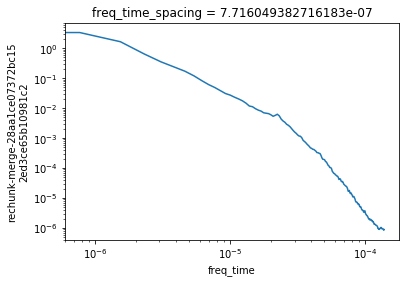

In [17]:
SSS_ps_t.mean(['time_segment','point']).plot()
plt.xscale('log')
plt.yscale('log')